<a href="https://colab.research.google.com/github/kmartellluya/fall_22_520_ML_Fairness_Toolkit/blob/main/520_VerifyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Install VerifyML in the terminal from jupyter notebook
!pip install verifyml

In [14]:
# Install tempeh in terminal from jupyter notebook
!pip install tempeh
from tempeh.configurations import datasets
# Extracting data set from compas Datsets
compas_dataset = datasets["compas"]()

In [96]:
import pandas as pd
# Split dataset - Train and test data
X_train, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train, y_test = compas_dataset.get_y(format=pd.Series)

print(f"Data set: X_train (1 sample):\n{X_train.loc[0]} \n\ny_train (1 sample):\nh{y_train[0]}")

Data set: X_train (1 sample):
age                        25.000000
juv_fel_count               0.000000
juv_misd_count             -2.340451
juv_other_count             1.000000
priors_count              -15.010999
age_cat_25 - 45             1.000000
age_cat_Greater than 45     0.000000
age_cat_Less than 25        0.000000
c_charge_degree_F           0.000000
c_charge_degree_M           1.000000
Name: 0, dtype: float64 

y_train (1 sample):
h1.0


In [9]:
import verifyml.model_card_toolkit as mctlib

# Initialize the Model Card Toolkit form VerifyML with a path 
# to store generate assets
mct = mctlib.ModelCardToolkit(output_dir="model_card_output", 
                              file_name="compas_model_card")
model_card = mct.scaffold_assets()

In [19]:
!pip install responsibly

In [16]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns

from responsibly.dataset import COMPASDataset
from responsibly.fairness.metrics import distplot_by

In [17]:
compas_ds = COMPASDataset()
df = compas_ds.df

6172

In [20]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [21]:
(((df['race'].value_counts() / len(df))
  * 100)
 .round(2))

African-American    51.44
Caucasian           34.07
Hispanic             8.25
Other                5.56
Asian                0.50
Native American      0.18
Name: race, dtype: float64

In [25]:
pd.crosstab(df['sex'], df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [94]:
import verifyml.model_card_toolkit as mctlib

# Initialize the Model Card Toolkit with a path to store generate assets
mct = mctlib.ModelCardToolkit(output_dir="model_card_output", 
                              file_name="compas_model_card")
model_card = mct.scaffold_assets()

In [27]:
# You can add free text fields
model_card.model_details.name = 'Compass Dataset'


In [99]:


import json
from IPython import display
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, precision_score, recall_score
from sklearn.pipeline import Pipeline


import verifyml.model_card_toolkit as mctlib
from verifyml.model_card_toolkit import model_card_pb2, ModelCard
from verifyml.model_tests.utils import plot_to_str
from verifyml.model_tests.FEAT import (
    SubgroupDisparity,
    MinMaxMetricThreshold,
    Perturbation,
    SHAPFeatureImportance,
    FeatureImportance,
    DataShift
)



In [110]:
x = df[[
  "sex",
  "age",
  # "age_cat",
  "race",
  # "juv_fel_count",
#   "decile_score",
  "juv_misd_count",
#   "juv_other_count",
  "priors_count",
#   "days_b_screening_arrest",
#   "c_case_number",
  "c_days_from_compas",
  "c_charge_degree",
#   "c_charge_desc",
  "is_recid",
#   "r_case_number",
#   "r_charge_degree",
  # "r_days_from_arrest", # Input contains NaN, infinity or a value too large for dtype('float32').
#   "r_charge_desc",
  # "violent_recid", # Input contains NaN, infinity or a value too large for dtype('float32').
  "is_violent_recid",
#   "vr_case_number",
#   "vr_charge_degree",
#   "vr_charge_desc",
#   "type_of_assessment",
  "decile_score",
#   "score_text",
#   "v_type_of_assessment",
#   "v_decile_score",
  "v_score_text",
  # "priors_count", # cannot reindex from a duplicate axis
  # "event",
]]

y = df["two_year_recid"]


# Train-Test data Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=50
)


# Build ML model with protected attributes as model features

# Apply one hot encoding to categorical columns (auto-detect object columns) 
# and random forest model in the pipeline
estimator = Pipeline(
    steps=[('onehot', ce.OneHotEncoder(use_cat_names=True)),
           ('classifier', RandomForestClassifier(n_estimators=2, 
                                                 max_features="sqrt", 
                                                 random_state = 88)
           )])


# Fit, predict and compute performance metrics
estimator.fit(x_train, y_train)

output = x_test.copy() # x_test df with output columns, to be appended later
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]

precision_train = round(precision_score(y_train, estimator.predict(x_train)),3)
recall_train = round(recall_score(y_train, estimator.predict(x_train)), 3)
precision_test = round(precision_score(y_test, y_pred),3)
recall_test = round(recall_score(y_test, y_pred), 3)


# Add output columns to this dataframe, to be used as a input for feat tests
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas


# Dataframe with categorical features encoded
x_train_encoded = estimator[0].transform(x_train)
x_test_encoded = estimator[0].transform(x_test)


# Get feature importance values
df_importance = pd.DataFrame(
    {"features": x_test_encoded.columns, 
     "value": estimator[-1].feature_importances_}
)


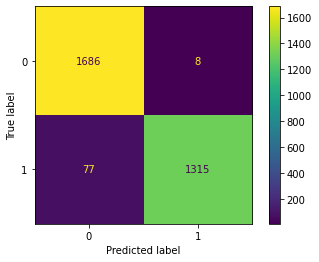

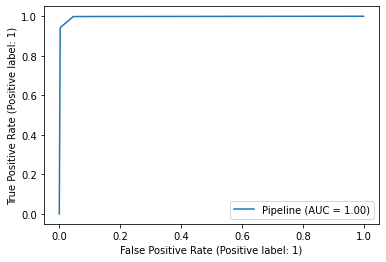

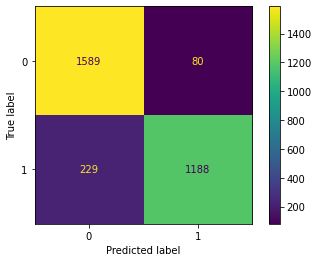

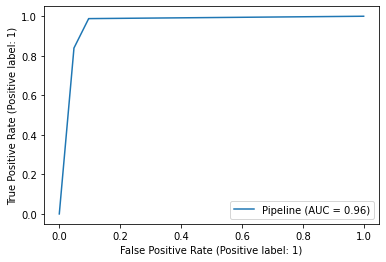

In [111]:
## Get ROC curves for both Train and test data set

# Train set
ConfusionMatrixDisplay.from_estimator(estimator, x_train, y_train)
confusion_matrix_train = plot_to_str()
RocCurveDisplay.from_estimator(estimator, x_train, y_train)
roc_curve_train = plot_to_str()

# Test set
ConfusionMatrixDisplay.from_estimator(estimator, x_test, y_test)
confusion_matrix_test = plot_to_str()
RocCurveDisplay.from_estimator(estimator, x_test, y_test)
roc_curve_test = plot_to_str()

In [112]:

from verifyml.model_tests.FEAT import SubgroupDisparity
df['truth'] = df['two_year_recid']
df['prediction'] = np.random.randint(2, size=6172)
sgd_test = SubgroupDisparity(
    attr='race',
    metric='fpr',
    method='ratio',
    threshold=2,  
)
sgd_test.run(df)

True

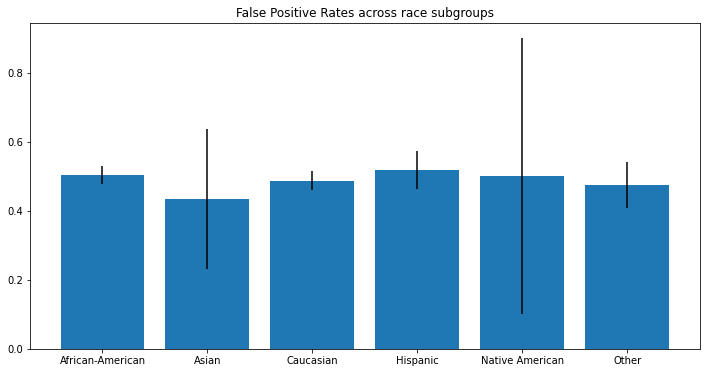

In [113]:

sgd_test.plot()

In [114]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['truth'], df['prediction'])

TN, FP, FN, TP = confusion_matrix(df['truth'], df['prediction']).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  1405
False Positive(FP) =  1669
True Negative(TN)  =  1694
False Negative(FN) =  1404


In [115]:
accuracy =  (TP + TN) / (TP + FP + TN + FN)

print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

Accuracy of the binary classifier = 0.502


In [116]:
from verifyml.model_tests.FEAT import MinMaxMetricThreshold
df['truth'] = df['two_year_recid']
df['prediction'] = np.random.randint(2, size=6172)
min_max_test = MinMaxMetricThreshold(
    attr='sex',
    metric='mae',
    threshold=0.025
)
min_max_test.run(df)

False

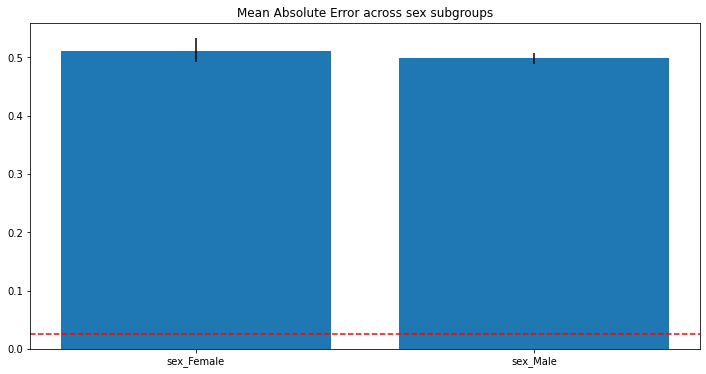

In [117]:
min_max_test.plot()